<a href="https://colab.research.google.com/github/nobobobo/An-Interpreter-In-Go/blob/master/kyonyu_on_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 巨乳顔検知器 ~ 50000 名のセクシー女優から学ぶ機械学習 ~

> あなたは「巨乳顔」という単語を聞いたことがありますか？ネット界隈では、最近よく耳にしたり、目にしたりすることも多いと思いますが、一体「巨乳顔」とは何なのでしょうか？

[「巨乳顔」ってなに？おっぱいが大きい女子の特徴・性格を大解剖！](https://girl.sugoren.com/report/1579793928029) より


# TL;DR

あとでかく

# 課題定義 　




(あとでかく)

# データセットの準備

このノートブックファイルと同じディレクトリに存在する scripts/data_collector.py を使用し、AV 女優データベース様から勝手に、およそ52000名のセクシー女優の名前(ひらがな)、カップ数、顔写真を引っ張ってきました。


主に Selenium + Chrome Web Driver を使用し、各セクシーの情報と女優の画像 URL を取得。Web クローリングなので、1ページ毎の女優数またページ数をして、ループでゴリ押し。

```
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

...

if __name__ == '__main__':

    NUM_PIC_PER_PAGE = 100
    NUM_PAGE = 520
    TOTAL_PIC = NUM_PAGE * NUM_PIC_PER_PAGE

    # open joyu.sexy (AV女優データベース)
    option = Options()
    option.add_argument('--headless')
    driver = webdriver.Chrome("../chromedriver", options=option)
    driver.get("http://joyu.sexy/?age_max=&age_min=&bust_max=&bust_min=&height_max=&height_min=&hip_max=&hip_min=&hits=" +
               str(NUM_PIC_PER_PAGE) + "&offset=1&q=&sort=-birthday&waist_max=&waist_min=#")

...

for pageNum in range(NUM_PAGE):
        for i in range(NUM_PIC_PER_PAGE):

...


```

その後、画像の URL に対して http request での画像を取得し書き込む: 

```
import requests

...

def download_file(url, filename_with_path):

    response = requests.get(url)
    image = response.content

    with open(filename_with_path, "wb") as file:
        file.write(image)
```

---



全ての女優を舐める (Web クローラーで) のに 14 時間ほどかかりました。

# データの前処理 (Preprocessing)

## ライブラリのインポート、データを見てみる

### ライブラリのインポート

諸々必要なライブラリを import してきます。

In [42]:
!pip install Pillow
!pwd

/content


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
%matplotlib inline

### 画像を見る (一枚)

**とりあえず画像を見てみたいですよね。**

In [44]:
test_img = plt.imread("drive/My Drive/kyonyu-face-recog/img/00040.jpg")
# test_img = plt.imread("img/00040.jpg")

print(test_img)
print(test_img.shape)

[[[152 120  99]
  [152 120  99]
  [151 119  98]
  ...
  [247 225 211]
  [247 225 211]
  [247 225 211]]

 [[147 115  94]
  [146 114  93]
  [146 114  93]
  ...
  [247 225 211]
  [247 225 211]
  [247 225 211]]

 [[148 116  95]
  [147 115  94]
  [147 115  94]
  ...
  [247 225 211]
  [247 225 211]
  [247 225 211]]

 ...

 [[202 145 115]
  [206 149 119]
  [212 156 123]
  ...
  [208 194 185]
  [213 199 190]
  [215 201 192]]

 [[203 146 116]
  [202 145 115]
  [208 152 119]
  ...
  [209 195 186]
  [215 201 192]
  [213 199 190]]

 [[210 153 123]
  [208 151 121]
  [212 156 123]
  ...
  [213 199 190]
  [219 205 196]
  [216 202 193]]]
(125, 125, 3)


おっと、失礼。これではベクターの形式でしたね。

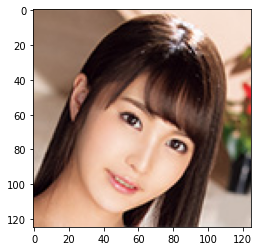

In [45]:
plt.imshow(test_img)

見れました！

### CSV データの取り込み

それでは ID:40 の画像に関して、csv から情報を読み取っていきます。

In [46]:
src = "drive/My Drive/kyonyu-face-recog/data.csv"
# src = "data.csv"
df = pd.read_csv(src,index_col=0)
print(df.head)

<bound method NDFrame.head of           name  cup
id                 
1        まきいずな    E
2        みつみあん    F
3        まえだもあ    I
4      あさひなななせ    D
5         やぎなな  NaN
...        ...  ...
51966     ----  NaN
51967     ----  NaN
51968     ----  NaN
51969     ----  NaN
51970     ----  NaN

[51970 rows x 2 columns]>


DataFrame の読み込みが完了しました。 

ただしデータフレームの末尾には名前(name) とカップ数(cup) が存在しない行もありますね。
後ほどいろいろいじっていきたいと思います。

In [47]:
print('Name: ', df.at[40, 'name'])
print('Cup: ', df.at[40, 'cup'])

Name:  しらいしあこ
Cup:  E


ID:40 で調べてみたところ、白石あこさんでした。**Eカップもある!**


### データフレームの概要＋ターゲットデータの処理

In [48]:
df.count()

name    51234
cup      6166
dtype: int64

何と、50000以上のデータを取り込みましたが、大多数の女優のカップ数が無効であるため、**結果として6166データしか残ってません...**

In [49]:
df['cup'].isnull().sum()

45804

ダブルチェック、やはり 45804 行が無効なデータだ。悲しい。

In [50]:
y_label = df['cup'].dropna()
print(y_label)
y_label.describe()

id
1        E
2        F
3        I
4        D
6        E
        ..
51878    N
51883    D
51897    F
51899    D
51904    G
Name: cup, Length: 6166, dtype: object


count     6166
unique      19
top          D
freq      1300
Name: cup, dtype: object

とりあえず、有効な 6166 行のデータを用いてラベル用のシリーズを作成。**D カップが一番多く 1300 件あるようだ。**

せっかくなので(分布を)可視化してみる。

### 分布の可視化

A      49
B     416
C    1223
D    1300
E    1052
F     852
G     643
H     309
I     168
J      75
K      42
L      14
M       8
N       2
O       6
P       3
Q       2
Z       1
p       1
Name: cup, dtype: int64


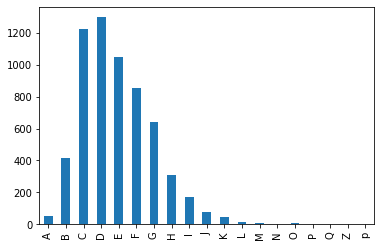

In [51]:
y_count = y_label.value_counts().sort_index()
print(y_count)
y_count.plot.bar()

気付き: 
1. Right Skew Distribution である。
2. 小文字の p カップが存在するため、後で処理が必要 
3. **Z カップってなんなん**


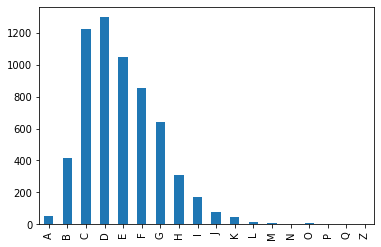

In [52]:
y_label = y_label.str.replace('p', 'P')
y_label.value_counts().sort_index().plot.bar()

**DONE!**

### 2クラスのターゲットデータの構成

y_label を用いてマルチクラス分類も可能だが、念のため 2 クラスのも用意
今回は Mode となる D 以上のデータを陽性 (Positive) とする。 

In [53]:
y_class = -y_label.isin(['A','B','C','D'])
y_class.describe()

count     6166
unique       2
top       True
freq      3178
Name: cup, dtype: object

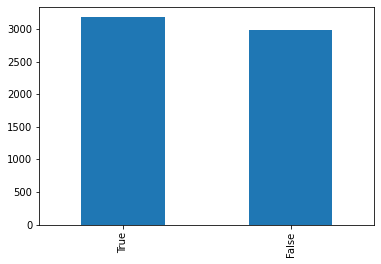

In [54]:
y_class.value_counts().plot.bar()

True/False のみで構成される Series が完成。

やや True の方が多い (Right Skew なので Median > Mode)

## 画像データの取り込み 

画像データを一括取り込みます。画像データの水増しもできるので OpenCV をインポートします。

In [55]:
!pip install opencv-python
import cv2
print(cv2.__version__)

4.1.2


In [56]:
ids = y_label.index.values
image_path = 'drive/My Drive/kyonyu-face-recog/img/'
# image_path = "img/"
images = []

for id in ids: 
  newImg = cv2.imread("{0}{1:05d}.jpg".format(image_path,id))

  # BGR画像なので RGB へと変換 
  img_rgb = cv2.cvtColor(newImg, cv2.COLOR_BGR2RGB)

  images.append(img_rgb)

error: ignored

おろ、なんかエラーが発生。

In [60]:
test = cv2.imread('drive/My Drive/kyonyu-face-recog/img/00054.jpg')

print(test)

None


なぜか ID: 54 の写真が None として読み込まれている。

(125, 125, 4)


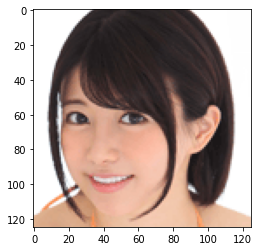

In [61]:
test = plt.imread('drive/My Drive/kyonyu-face-recog/img/00054.jpg')

print(test.shape)

plt.imshow(test)

pyplot では読み込みが成功。レイヤーが4つある。

調べたところ [alpha channel](https://stackoverflow.com/questions/21652732/how-to-read-the-alpha-channel-of-a-tiff-image-in-python-opencv) というものらしい　

(125, 125, 3)


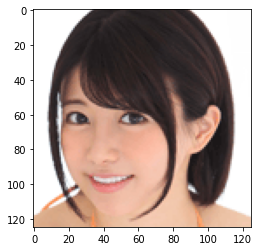

In [117]:
test_drop4 = test[:,:,:3]
print(test_drop4.shape)
plt.imshow(test_drop4)

4レイヤー目を drop したが特に画像に対し影響がないようにみられるので、例外処理として pandas での読み込みが None である場合は plt で読み込む

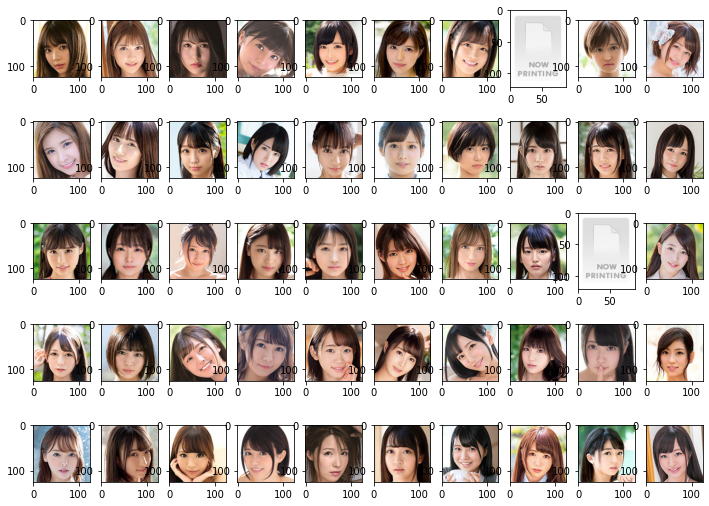

In [59]:
ids = y_label.index.values
image_path = 'drive/My Drive/kyonyu-face-recog/img/'
# image_path = "img/"
images = []

for id in ids: 
  newImg = cv2.imread("{0}{1:05d}.jpg".format(image_path,id))

  if np.shape(newImg) == ():
    newImg = plt.imread("{0}{1:05d}.jpg".format(image_path,id))
    img_rgb = newImg[:,:,:3]
    
  else:
    img_rgb = cv2.cvtColor(newImg, cv2.COLOR_BGR2RGB)

  images.append(img_rgb)

# plot
fig = plt.figure(figsize=(12,9))
subfig = []
ROWS_COUNT = 5
COLUMNS_COUNT =10

for i in range(1, 51): # 1 ~ len(images)+1:
  subfig.append(fig.add_subplot(ROWS_COUNT, COLUMNS_COUNT, i))

  subfig[i-1].imshow(images[i-1])

plt.show()

In [62]:
len(images)

6166

うまく cv2 (時折 plt) で画像を読み込むことができました。

気付き: 

NOW PRINTING をどうにかしないと。

またこの後 subplot は多く使うので関数を定義　

In [0]:
def plotMulti(numRow, numCol, imgList):
    fig = plt.figure(figsize=(12,9))
    subfig = []

    for i in range(1, len(imgList)+1): # 1 ~ len(images)+1:
        subfig.append(fig.add_subplot(numRow, numCol, i))

        subfig[i-1].imshow(imgList[i-1])

    plt.show()

### ノイズ画像の処理


**お、Now Printing の画像は正方形ではなく、縦長だ**

In [63]:
# 通常の写真のサイズ 

print(images[0].shape)
print(images[10].shape)
print(images[100].shape)
print(images[1000].shape)


(125, 125, 3)
(125, 125, 3)
(125, 125, 3)
(125, 125, 3)


通常の写真は 125 x 125 x 3 

In [64]:
# Now Printing の画像サイズ

print(images[7].shape)
print(images[28].shape)
print(images[61].shape)

(122, 90, 3)
(122, 90, 3)
(122, 90, 3)


122 x 90 x 3 なので、何枚 Now Printing が存在するか確認。

In [65]:
# Now Printing のデータサイズを確認
print(sum([image.shape == (122, 90, 3) for image in images]))

# 通常の写真サイズとこなるデータのサイズ確認
print(sum([image.shape != (125, 125, 3) for image in images]))

1239
1276


40 枚ほど 125 x 125 ではないが、Now Printing となる 122 x 90 にも該当しない写真がある。どういうものか見てみる。 

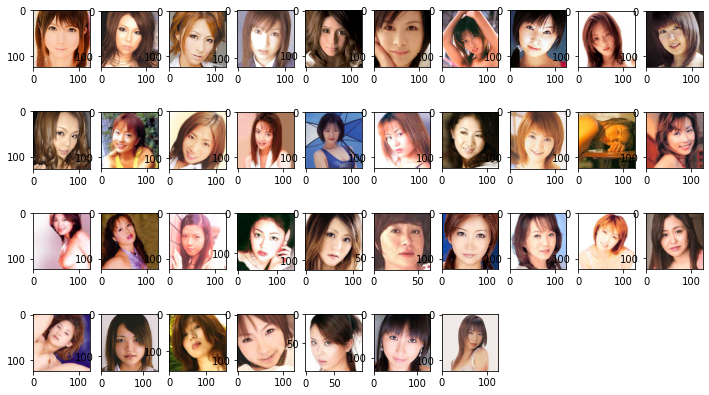

Size of rest[0]:  (126, 125, 3)
Size of rest[10]:  (128, 125, 3)
Size of rest[20]:  (124, 125, 3)


In [66]:
rest = list(filter(lambda img: img.shape != (125, 125, 3) and img.shape != (122, 90, 3), images))

plotMulti(5, 10, rest)

print('Size of rest[0]: ', rest[0].shape)
print('Size of rest[10]: ', rest[10].shape)
print('Size of rest[20]: ', rest[20].shape)

若干のピクセルの差異がある写真だ。とりあえず 125x125 未満のやつは除去し、以上のやつは 125x125 部分を後でクロップをする。

_(気のせいかしれないけど、だいぶ時代を感じる写真たちですね。)_

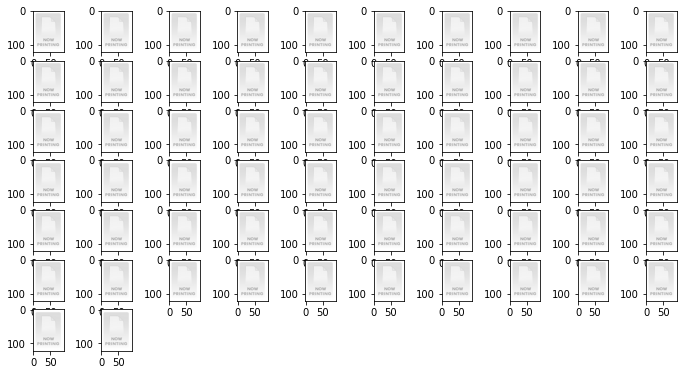

In [67]:
nowPrintingList = list(filter(lambda img: img.shape == (122, 90, 3), images))

plotMulti(10, 10, nowPrintingList[::20])


122 x 90 は Now Printing で問題なさそう。

なので、このサイズに該当しない画像を有効画像として、その id を ids に残す。

同時にサイズが若干違うやつはクロップする 

In [68]:
# images と ids の長さを確認 

print('Length of orginal Image List: ', len(images))
print('Length of original ID List: ', len(ids))


print('Start convert...')

Length of orginal Image List:  6166
Length of original ID List:  6166
Start convert...


In [118]:
# 有効な写真を持つデータセット imageData を構築 
# (Now Printing + サイズが小さい写真は除外済み、)
hasImgIndex = np.array([image.shape >= (125, 125, 3) for image in images])
imageData = np.array(images)[hasImgIndex]

# 有効な写真を持つ ID の配列 imageIds を構成
imageIds = np.array(ids)[hasImgIndex]

print("Length of filtered image list: ", len(imageIds))
print("Length of filtered id list: ", len(imageData))


Length of filtered image list:  4907
Length of filtered id list:  4907


In [70]:
# サイズが大きい写真のクロップ
# idx 673 の写真が若干大きいので、オリジナルサイズを print

print("Original size", imageData[673].shape)

for idx, img in enumerate(imageData):
    if img.shape > (125, 125, 3):
        imageData[idx] = img[:125, :125, :]

print("after crop", imageData[673].shape)

Original size (126, 125, 3)
after crop (125, 125, 3)


In [71]:
# サンプルデータの処理は完了。サイズを確認。

print("# of samples:", len(imageData))

# of samples: 4907


Sample ID:  165


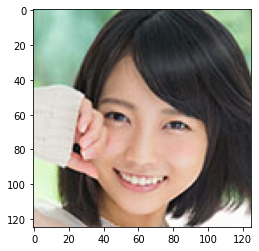

In [72]:
# 念のため np.array 化した写真を参照可能か、確認: 
plt.imshow(imageData[124])
print('Sample ID: ',imageIds[124])

**素晴らしい** 

元データの ID: 165 を見てみて、問題なしかチェック

Name:  とだまこと
Cup:  C


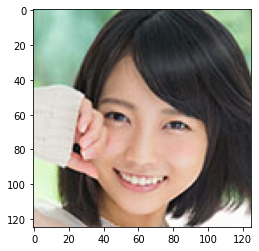

In [74]:
print('Name: ', df.at[165, 'name'])
print('Cup: ',df.at[165, 'cup'])

plt.imshow(plt.imread('drive/My Drive/kyonyu-face-recog/img/00165.jpg'))

**完璧です** 

次はターゲットデータとなるラベリング (y_label) とクラスデータ (y_class) を処理

In [75]:
# imageIds より Cups の配列を取得 
# 念のため y_label と y_class の長さを再確認 

print('length of original y_label:', len(y_label.index))
print('length of original y_class:', len(y_class.index))


print('Convert...')
label_data = y_label[hasImgIndex]
class_data = y_class[hasImgIndex]

print('Length of converted label_data:', len(label_data.index))
print('Length of converted class_data:', len(class_data.index))


length of original y_label: 6166
length of original y_class: 6166
Convert...
Length of converted label_data: 4907
Length of converted class_data: 4907


既存のデータの処理が完了。結果として現在以下の変数が学習に用いられる。

* imageData: 4907 x 画像サイズ (125x125x3) の 学習データ (結果としては 4907, 46875 のベクターになる)
* label_data: 画像サイズと同様の長さ (4907 行) の pd.Series. (id, cup) の構成
* class_data: 画像サイズと同様の長さ (4907 行) の pd.Series. (id, cup> 'D' ) の構成


有効データがだいぶ減り、特徴量も多いので、画像の Reduce もしくはデータの水増しも検討します

In [77]:
plt_img = plt.imread("drive/My Drive/kyonyu-face-recog/img/00040.jpg")
cv2_img = cv2.imread("drive/My Drive/kyonyu-face-recog/img/00040.jpg")
cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)

np.alltrue(plt_img == cv2_img)

True

念のため、plt と cv2 で読みまれた画像が同一か確認: True でよかった。

### 画像データの Resize と Reduce 


まずは 125x125 の画像サイズをどのサイズまで縮小可能かみていきます。

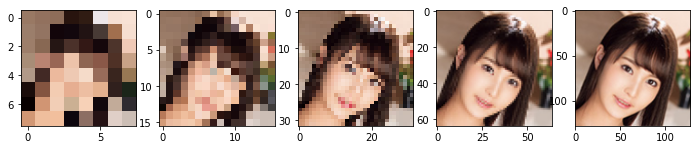

In [78]:
# resize target size を指定
sizes = [8, 16, 32, 64, 128]

fig = plt.figure(figsize=(12,9))
subfig = []
ROWS_COUNT = 1
COLUMNS_COUNT =5

for i in range(1, 6):
    # 目標サイズへと縮小
    size = sizes[i-1]
    resized = cv2.resize(test_img, (size, size))
    
    subfig.append(fig.add_subplot(ROWS_COUNT, COLUMNS_COUNT, i))
    subfig[i-1].imshow(resized)

plt.show()

結果としては 64x64 と 128x128 がまだ顔の詳細を認識すること可能なレベルなので、64x64 へと resize します。

In [79]:
target_size = 64
target_dim = (target_size, target_size)

imageData_resized = imageData.copy()

# resize and append to new set of array
for idx, img in enumerate(imageData):
    resized = cv2.resize(img, target_dim)
    imageData_resized[idx] = resized

print('Resizing Done!')

Resizing Done!


In [80]:
print(imageData_resized[7].shape)

(64, 64, 3)


これで 150x150 px の画像を 64x64 の 3 チャンネルへと変換完了 

次は画像を 1D vector へと reduce

In [81]:
print('Dim of ImageData_resized:', imageData_resized.ndim)
print('Dim of first image_resized:', imageData_resized[0].ndim)

Dim of ImageData_resized: 1
Dim of first image_resized: 3


In [82]:
imageData_flat = imageData_resized[0].reshape(-1)

print(imageData_flat)
print(len(imageData_flat))

[253 255 249 ... 196 150 101]
12288


In [83]:
imageData_reduced = imageData_resized.copy()

for i in range(len(imageData_resized)): 
    imageData_reduced[i] = imageData_resized[i].reshape(-1)

print('Reducing Done!')

Reducing Done!


# 学習

今回は Support Vector Machine の SVC を使って学習します。

## データの分類 

まずは画像データとターゲットデータを訓練用、検証用にランダムで分類します。

割合としては 8:2 にします。


In [84]:
# Series の ndarray 化の方法を確認
print(class_data.to_numpy())


[ True  True  True ...  True False  True]


In [85]:
# skelarn より train_test_split を import
!pip install scikit-learn
from sklearn.model_selection import train_test_split

# まずは Test Data を抽出
X_train, X_test, y_train, y_test = train_test_split(list(imageData_reduced), class_data.to_numpy(), test_size = 0.2, random_state=0)

In [86]:
print("# of train samples:" ,len(X_train))
print("# of train labels:" ,len(y_train))
print('----------------------')
print("# of test samples:" ,len(X_test))
print("# of test labels:" ,len(y_test))

# of train samples: 3925
# of train labels: 3925
----------------------
# of test samples: 982
# of test labels: 982


これで以下の通りデータが SPLIT できました。

* 訓練データ (x_train, Y_train): 3925 件
* 検証データ (x_test, Y_test): 982 件

## ライブラリのインポートと分類器の作成

scikit-learn の Support Vector Classifier （SVC) を使用して、input: vector output: True/False といったモデルを学習します。

In [0]:
from sklearn import svm, metrics

model = svm.SVC(gamma=0.001)

とりあえず学習させて見ます。

In [88]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

model.fit(X_train, y_train)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Finish Time =", current_time)

Start Time = 00:38:02
Finish Time = 00:43:15


学習にはおよそ 5 分かかった。

# モデルの評価

## 学習済みモデルの評価



### 訓練データでのパフォーマンス

In [0]:
prediction_train = model.predict(X_train)

In [98]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def evaluateModel(expected, predicted):
  clf_report = classification_report(expected, predicted)
  print(clf_report)

  conf_mx = confusion_matrix(expected, predicted)
  print(conf_mx)

evaluateModel(y_train, prediction_train)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1868
        True       1.00      1.00      1.00      2057

    accuracy                           1.00      3925
   macro avg       1.00      1.00      1.00      3925
weighted avg       1.00      1.00      1.00      3925

[[1867    1]
 [   0 2057]]


訓練データのパフォーマンス: Precision, Recall, Accuracy が 100%。Overfit 臭いですね

### 検証データに対する評価

In [0]:
prediction_test = model.predict(X_test)

In [99]:
evaluateModel(y_test, prediction_test)

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       470
        True       0.52      1.00      0.69       512

    accuracy                           0.52       982
   macro avg       0.26      0.50      0.34       982
weighted avg       0.27      0.52      0.36       982

[[  0 470]
 [  0 512]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


検証データではイマイチな結果になりましたね。Overfitting してしまったのかも。

画像データの Normalization をやっていなかったので、一度 Normalization を試し、評価してみる。

### Normalization による性能向上の有無に関して

In [106]:
X_train_norm, X_test_norm, y_train, y_test = train_test_split(list(imageData_reduced/255), class_data.to_numpy(), test_size = 0.2, random_state=0)

model_norm = svm.SVC(gamma=0.001)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

model_norm.fit(X_train_norm, y_train)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Finish Time =", current_time)

Start Time = 01:03:24
Finish Time = 01:08:28


In [107]:
prediction_train_norm = model_norm.predict(X_train_norm)
prediction_test_norm = model_norm.predict(X_test_norm)

print("Train Data Evaluation: ")
evaluateModel(y_train, prediction_train_norm)

print("Test Data Evaluation: ")
evaluateModel(y_test, prediction_test_norm)

Train Data Evaluation: 
              precision    recall  f1-score   support

       False       0.86      0.72      0.79      1868
        True       0.78      0.90      0.83      2057

    accuracy                           0.81      3925
   macro avg       0.82      0.81      0.81      3925
weighted avg       0.82      0.81      0.81      3925

[[1349  519]
 [ 211 1846]]
Test Data Evaluation: 
              precision    recall  f1-score   support

       False       0.52      0.43      0.47       470
        True       0.55      0.64      0.59       512

    accuracy                           0.54       982
   macro avg       0.54      0.54      0.53       982
weighted avg       0.54      0.54      0.53       982

[[200 270]
 [182 330]]


正規化のよって、訓練データのパフォーマンスは落ちたが、検証データに対するパフォーマンスが若干向上。

やはり正規化は大事だ。しかしそれでもテストデータに対する F1 Score が 54%。低いですね

## 交差検証によるモデルの評価

交差検証でのパフォーマンスを評価。


In [108]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

accuracy, precision, recall = cross_val_score(model, X_train_norm, y_train, cv=3, scoring='f1')
print('accuracy: {0}, precision: {1}, recall: {2}'.format(round(accuracy * 100, 1), round(precision * 100, 1), round(recall * 100, 1)))

accuracy: 61.4, precision: 61.6, recall: 60.2


In [109]:
y_train_pred = cross_val_predict(model, X_train_norm, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[ 768 1100]
 [ 670 1387]]


交差検証を交えて学習させたところ、Accuracy, Precision, Recall が全て 60% ほど

Confusion Matrix もイマイチ

## 最適パラメータの検索

時間はかかるが、Grid_search で最適なパラメータを探す。

In [0]:
from sklearn.model_selection import GridSearchCV

def do_grid_search(X, y):
  param_grid = {
      'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
      'gamma' : [0.001, 0.001, 0.01, 0.1, 1, 10, 100] }
  grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5, scoring='f1')
  grid_search.fit(X, y)
  print('Test set score: {}'.format(grid_search.score(X_test_norm, y_test)))
  print('Best parameters: {}'.format(grid_search.best_params_))
  print('Best cross-validation: {}'.format(grid_search.best_score_))

# 最適パラメータは一度求めたら再計算は不要
# do_grid_search(X_train_norm, y_train)

Normalization なしの状態では、以下の結果が排出された。結局デフォルトのパラメータが一番よかったらしい。

```
Test set score: 0.6854082998661312
Best parameters: {'C': 1, 'gamma': 0.001}
Best cross-validation: 0.6877399910873916
```

## 学習曲線

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


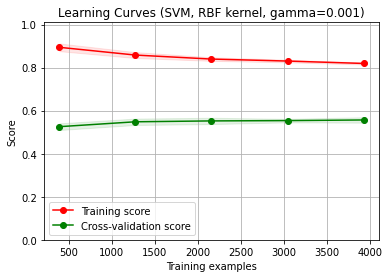

In [116]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

  plt.figure()
  plt.title(title)

  if ylim is not None:
    plt.ylim(*ylim)

  plt.xlabel("Training examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(
      estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis = 1)
  train_scores_std = np.std(train_scores, axis = 1)
  test_scores_mean = np.mean(test_scores, axis = 1)
  test_scores_std = np.std(test_scores, axis = 1)
  plt.grid()

  plt.fill_between(
      train_sizes, train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std, alpha=0.1,
      color="r")
  plt.fill_between(
      train_sizes, test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std, alpha=0.1,
      color = "g")
  plt.plot(
      train_sizes, train_scores_mean, 'o-', color="r",
      label="Training score")
  plt.plot(
      train_sizes, test_scores_mean, 'o-', color="g",
      label="Cross-validation score")

  plt.legend(loc="best")
  return plt

X = np.concatenate((X_train_norm, X_test_norm), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

title = "Learning Curves (SVM, RBF kernel, gamma=0.001)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = svm.SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.0, 1.01), cv=cv, n_jobs=4)
plt.show()

CV のスコアはサンプル数上昇に伴い増加している。ただし微量

# その他のモデルに関して

SVC で学習したが、約 60% ほどの精度 (f1-score) しか出ないので、その他のモデルも見てみる。


https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 

このリンクのような方法での比較もあるので、とりあえず、KNeighbors, Decision Tree, Random Forest, Neural Net,  SVM で比較してみる。

In [115]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#複数の classifier の作成
models = []
models.append(("KNC",KNeighborsClassifier()))
models.append(("DTC",DecisionTreeClassifier()))
models.append(("RFC",RandomForestClassifier()))
models.append(("MLP",MLPClassifier()))
models.append(("SVM",svm.SVC()))

#複数のclassifier の適用
results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=10, random_state=42)
    result = cross_val_score(model,X_train_norm ,y_train, cv = kfold, scoring = "f1")
    names.append(name)
    results.append(result)

#適用したclassifierのスコア表示
for i in range(len(names)):
    print(names[i],results[i].mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will ra

KNC 0.5454851866034017
DTC 0.5283887805835148
RFC 0.5890574337001365
MLP 0.5803791648214773
SVM 0.6179642724685628


結局 SVM の方が良いようだ。